In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass

try:
    import tensorflow_addons as tfa
except:
    !pip install tensorflow-addons
    import tensorflow_addons as tfa

try:
  import wandb
except:
  !pip install --upgrade -q wandb
  import wandb

from wandb.keras import WandbCallback
from functools import partial
from sklearn.metrics import accuracy_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 7.9 MB/s eta 0:00:00


In [14]:
@dataclass
class C:
    DECAY = 1e-6
    EPOCHS = 100
    LR = 2e-2
    HEIGHT = 224
    BATCH_SIZE = 256
    AUTO = tf.data.experimental.AUTOTUNE
    SEED = 42
    BUFFER_SIZE = 1028
    SHAPE = [HEIGHT,HEIGHT]
    SCALE = (0.2,1.0)
    NUM_CLASSES = 5
    PATH = "/content/WEIGHTS_2023 03 05.h5"

In [3]:
wandb.login()
wandb.init(
    project="vicreg_tpu",
    config={
        "learning_rate": C.LR,
        "batch_size": C.BATCH_SIZE,
        "optimizer" : "cosing decay schedule",
        "model": "Resnet50"
    },
    group = "ResNet",
    job_type = "evaluation"
)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: atiaisaac007. Use `wandb login --relogin` to force relogin


In [4]:
@tf.function
def _distorted_bounding_box_crop(
  image,bbox,min_object_covered=0.1,
  aspect_ratio_range=(0.75,1.33),
  area_range=(0.05,0.1),max_attempts=100
):
  shape = tf.shape(image)
  random_distorted_bbox = tf.image.sample_distorted_bounding_box(
      shape,
      bounding_boxes = bbox,
      min_object_covered = min_object_covered,
      aspect_ratio_range = aspect_ratio_range,
      area_range = area_range,
      max_attempts = max_attempts
  )
  offset,size,_ = random_distorted_bbox
  offset_y,offset_x,_ = tf.unstack(offset)
  target_y,target_x,_ = tf.unstack(size)
  image = tf.image.crop_to_bounding_box(
      image,offset_y,offset_x,target_y,target_x
  )
  return image

@tf.function    
def random_crop_resize(image,height,width,area_range=(0.08,1.0)):
  bbox = tf.constant([0.,0.,1.,1.],dtype=tf.float32,shape=[1,1,4])
  # aspect_ratio = height / width
  image = _distorted_bounding_box_crop(
      image,bbox,
      area_range=area_range               
  )
  image = tf.image.resize(image,[height,width],method="bicubic")
  return image

In [5]:
train,val = tfds.load(
    "tf_flowers",
    as_supervised = True,
    split = ["train[:80%]","train[80%:]"],
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [6]:
@tf.function
def augmentation(image,label,transform="train"):
  if transform == "train":
    image = random_crop_resize(image,C.HEIGHT,C.HEIGHT,area_range=C.SCALE)
    image = tf.image.random_flip_left_right(image)
    image = tf.clip_by_value(image,0,255)
    return image,label
  elif transform == "val":
    image = tf.image.central_crop(image,0.7)
    image = tf.image.resize(image,[C.HEIGHT,C.HEIGHT],method="bicubic")
    image = tf.clip_by_value(image,0,255)
    return image,label

In [7]:
train_ds = train.map(partial(augmentation,transform="train"))
train_ds = train_ds.shuffle(C.BUFFER_SIZE)
train_ds = train_ds.batch(C.BATCH_SIZE)
train_ds = train_ds.prefetch(C.AUTO)


val_ds = val.map(partial(augmentation,transform="val"))
val_ds = val_ds.batch(C.BATCH_SIZE)
val_ds = val_ds.prefetch(C.AUTO)

In [8]:
def visualize(sample):
  x,y = sample
  plt.figure(figsize=(10, 10))
  for n in range(25):
      ax = plt.subplot(5, 5, n + 1)
      plt.imshow(x[n].numpy().astype("int"))
      plt.title(str(y[n].numpy()))
      plt.axis("off")
  plt.show()

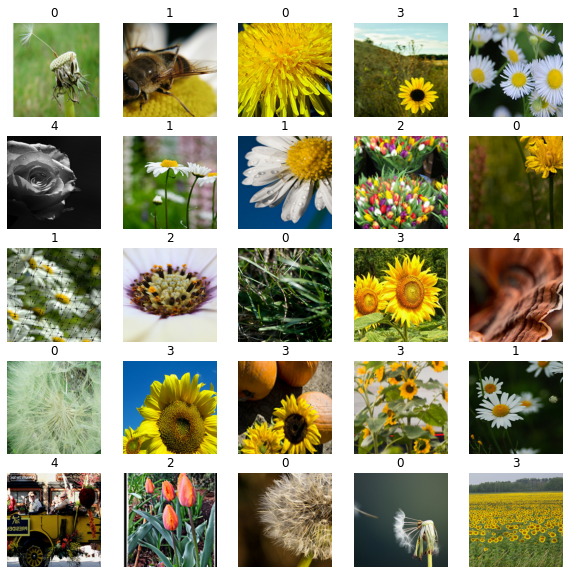

In [9]:
train_sample_one = next(iter(train_ds))
visualize(train_sample_one)

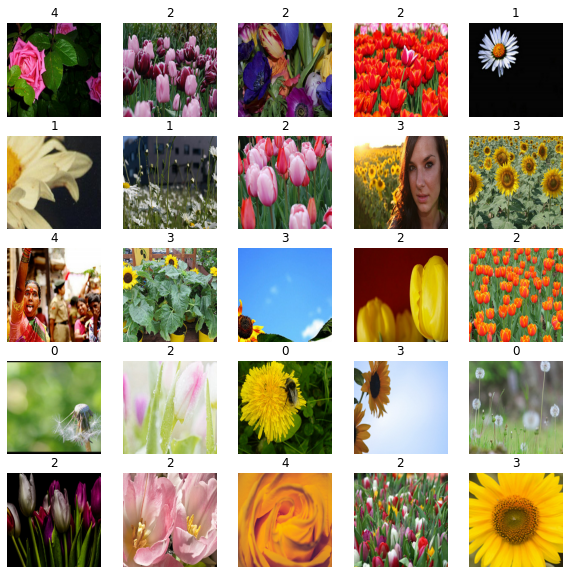

In [10]:
train_sample_two = next(iter(val_ds))
visualize(train_sample_two)

In [11]:
class Block(tf.keras.Model):
  def __init__(self,filters,strides=1,padding="same",initializer="lecun_uniform",use_bias=False):
    super(Block,self).__init__()

    self.conv1 = tf.keras.layers.Conv2D(filters,kernel_size=3,strides=strides,
                                        padding=padding,kernel_initializer=initializer,
                                        use_bias=use_bias)
    self.sb1 = tf.keras.layers.experimental.SyncBatchNormalization(epsilon=1.001e-5)
    self.conv2 = tf.keras.layers.Conv2D(filters,kernel_size=3,strides=1,
                                        padding=padding,kernel_initializer=initializer,
                                        use_bias=use_bias)
    self.sb2 = tf.keras.layers.experimental.SyncBatchNormalization(epsilon=1.001e-5)

    if strides != 1:
      self.downsample = tf.keras.Sequential()
      self.downsample.add(tf.keras.layers.Conv2D(filters,kernel_size=1,strides=strides,
                                                 kernel_initializer=initializer,
                                        use_bias=use_bias))
      self.downsample.add(tf.keras.layers.experimental.SyncBatchNormalization(epsilon=1.001e-5))

    else:
      self.downsample = lambda x: x

  def call(self,inputs):
    residual = self.downsample(inputs)

    x = self.conv1(inputs)
    x = self.sb1(x)
    x = tf.nn.relu(x)
    x = self.conv2(x)
    x = self.sb2(x)
    x = tf.nn.relu(tf.keras.layers.add([residual,x]))
    return x


def make_block(reps,filters,strides=1):
  block = tf.keras.Sequential()
  block.add(Block(filters,strides=strides))
  for i in range(1,reps):
    block.add(Block(filters,strides=1))

  return block


class ResNet18(tf.keras.Model):
  def __init__(self):
    super(ResNet18,self).__init__()

    # Block-1
    self.conv1 = tf.keras.layers.Conv2D(
        filters=64,kernel_size=7,strides=2,use_bias = False,
        kernel_initializer = "lecun_uniform",padding="same")
    self.bn1 = tf.keras.layers.experimental.SyncBatchNormalization(epsilon=1.001e-5)
    self.act1 = tf.keras.layers.ReLU()
    self.pool = tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding="same")
    self.bn2 = tf.keras.layers.experimental.SyncBatchNormalization(epsilon=1.001e-5)

    # Identity blocks
    self.blk2 = make_block(reps=2,filters=64,strides=1)
    self.blk3 = make_block(reps=2,filters=128,strides=2)
    self.blk4 = make_block(reps=2,filters=256,strides=2)
    self.blk5 = make_block(reps=2,filters=512,strides=2)

  def call(self,inputs):
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = self.act1(x)
    x = self.pool(x)
    x = self.bn2(x)
    x = self.blk2(x)
    x = self.blk3(x)
    x = self.blk4(x)
    x = self.blk5(x)
    return x

In [12]:
backbone = ResNet18()

In [15]:
encoder = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1./255.),
    backbone,
    tf.keras.layers.GlobalAveragePooling2D()
])
encoder.build([None,224,224,3])
encoder.load_weights(C.PATH)
encoder.trainable = False

In [16]:
def lincls(num_classes):
  i = tf.keras.Input(shape=[224,224,3])
  x = encoder(i,training=False)
  o = tf.keras.layers.Dense(num_classes,activation="softmax")(x)
  return tf.keras.Model(inputs=i,outputs=o)

model = lincls(C.NUM_CLASSES)

In [17]:
total_steps = train_ds.cardinality().numpy() * C.EPOCHS
steps_per_epoch = train_ds.cardinality().numpy()
val_steps = val_ds.cardinality().numpy()

scheduler = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = C.LR,
    decay_steps = total_steps
)
optimizer = tfa.optimizers.SGDW(
    learning_rate = scheduler,
    weight_decay = C.DECAY,
    momentum=0.9
)

In [18]:
model.compile(
    optimizer = optimizer,
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

In [19]:
model.fit(
    train_ds,
    steps_per_epoch = steps_per_epoch,
    validation_data = val_ds,
    validation_steps = val_steps,
    epochs = C.EPOCHS,
    callbacks = [WandbCallback()],
    verbose = 1
)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/100
12/12 [==============================] - ETA: 0s - loss: 23.3716 - accuracy: 0.2357

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.3s


12/12 [==============================] - 47s 3s/step - loss: 23.3716 - accuracy: 0.2357 - val_loss: 35.3221 - val_accuracy: 0.3093
Epoch 2/100
12/12 [==============================] - ETA: 0s - loss: 19.1873 - accuracy: 0.3702

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 28s 2s/step - loss: 19.1873 - accuracy: 0.3702 - val_loss: 15.4313 - val_accuracy: 0.4360
Epoch 3/100
12/12 [==============================] - ETA: 0s - loss: 10.0007 - accuracy: 0.4159

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 27s 2s/step - loss: 10.0007 - accuracy: 0.4159 - val_loss: 9.2948 - val_accuracy: 0.3542
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 6.4179 - accuracy: 0.4254

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 27s 2s/step - loss: 6.4179 - accuracy: 0.4254 - val_loss: 5.5312 - val_accuracy: 0.4550
Epoch 5/100
12/12 [==============================] - 8s 540ms/step - loss: 5.5081 - accuracy: 0.3937 - val_loss: 8.0766 - val_accuracy: 0.4196
Epoch 6/100
12/12 [==============================] - 7s 490ms/step - loss: 7.4070 - accuracy: 0.3818 - val_loss: 9.3588 - val_accuracy: 0.3665
Epoch 7/100
12/12 [==============================] - 9s 549ms/step - loss: 9.6283 - accuracy: 0.3648 - val_loss: 7.9614 - val_accuracy: 0.4264
Epoch 8/100
12/12 [==============================] - 9s 609ms/step - loss: 5.1975 - accuracy: 0.4397 - val_loss: 7.5318 - val_accuracy: 0.4346
Epoch 9/100
12/12 [==============================] - 7s 478ms/step - loss: 10.7456 - accuracy: 0.3341 - val_loss: 8.7367 - val_accuracy: 0.3774
Epoch 10/100
12/12 [==============================] - 8s 555ms/step - loss: 7.2787 - accuracy: 0.4118 - val_loss: 6.8459 - val_accuracy: 0.4087
Epoch 11/10

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.3s


12/12 [==============================] - 27s 2s/step - loss: 6.9619 - accuracy: 0.4584 - val_loss: 4.3457 - val_accuracy: 0.4619
Epoch 14/100
12/12 [==============================] - 7s 477ms/step - loss: 4.9048 - accuracy: 0.4203 - val_loss: 7.0556 - val_accuracy: 0.3392
Epoch 15/100
12/12 [==============================] - 8s 477ms/step - loss: 4.9599 - accuracy: 0.4275 - val_loss: 5.6332 - val_accuracy: 0.4019
Epoch 16/100
12/12 [==============================] - 8s 532ms/step - loss: 7.1699 - accuracy: 0.3471 - val_loss: 16.5926 - val_accuracy: 0.2330
Epoch 17/100
12/12 [==============================] - 7s 488ms/step - loss: 12.1521 - accuracy: 0.3699 - val_loss: 8.1085 - val_accuracy: 0.4414
Epoch 18/100
12/12 [==============================] - 9s 573ms/step - loss: 6.8359 - accuracy: 0.4257 - val_loss: 4.7834 - val_accuracy: 0.4441
Epoch 19/100
12/12 [==============================] - 8s 526ms/step - loss: 7.1727 - accuracy: 0.3883 - val_loss: 5.6776 - val_accuracy: 0.4169
Epoch

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 27s 2s/step - loss: 6.3482 - accuracy: 0.4240 - val_loss: 4.2469 - val_accuracy: 0.5163
Epoch 26/100
12/12 [==============================] - 8s 530ms/step - loss: 4.7375 - accuracy: 0.4513 - val_loss: 4.8723 - val_accuracy: 0.3665
Epoch 27/100
12/12 [==============================] - 7s 487ms/step - loss: 5.1807 - accuracy: 0.4118 - val_loss: 5.8909 - val_accuracy: 0.3883
Epoch 28/100
12/12 [==============================] - 8s 537ms/step - loss: 4.6090 - accuracy: 0.4377 - val_loss: 5.0454 - val_accuracy: 0.3896
Epoch 29/100
12/12 [==============================] - 8s 604ms/step - loss: 6.6054 - accuracy: 0.3624 - val_loss: 7.4325 - val_accuracy: 0.4455
Epoch 30/100
12/12 [==============================] - 8s 483ms/step - loss: 8.6158 - accuracy: 0.4217 - val_loss: 4.6603 - val_accuracy: 0.4973
Epoch 31/100
12/12 [==============================] - ETA: 0s - loss: 5.0736 - accuracy: 0.4421

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 27s 2s/step - loss: 5.0736 - accuracy: 0.4421 - val_loss: 3.2571 - val_accuracy: 0.4918
Epoch 32/100
12/12 [==============================] - 8s 489ms/step - loss: 3.8628 - accuracy: 0.4455 - val_loss: 3.2588 - val_accuracy: 0.4659
Epoch 33/100
12/12 [==============================] - 8s 510ms/step - loss: 7.0521 - accuracy: 0.3699 - val_loss: 7.1167 - val_accuracy: 0.3624
Epoch 34/100
12/12 [==============================] - 9s 619ms/step - loss: 6.6903 - accuracy: 0.3958 - val_loss: 5.3519 - val_accuracy: 0.4155
Epoch 35/100
12/12 [==============================] - 7s 484ms/step - loss: 5.4962 - accuracy: 0.4349 - val_loss: 3.4337 - val_accuracy: 0.4782
Epoch 36/100
12/12 [==============================] - 7s 482ms/step - loss: 4.0179 - accuracy: 0.4370 - val_loss: 4.5312 - val_accuracy: 0.3965
Epoch 37/100
12/12 [==============================] - 8s 568ms/step - loss: 5.4052 - accuracy: 0.3808 - val_loss: 10.9539 - val_accuracy: 0.3638
Epoch 

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 27s 2s/step - loss: 2.6478 - accuracy: 0.4523 - val_loss: 3.1489 - val_accuracy: 0.4128
Epoch 44/100
12/12 [==============================] - 8s 486ms/step - loss: 3.6324 - accuracy: 0.4414 - val_loss: 4.3871 - val_accuracy: 0.4005
Epoch 45/100
12/12 [==============================] - 10s 680ms/step - loss: 2.7842 - accuracy: 0.4598 - val_loss: 3.4953 - val_accuracy: 0.3965
Epoch 46/100
12/12 [==============================] - ETA: 0s - loss: 2.4005 - accuracy: 0.4636

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 26s 2s/step - loss: 2.4005 - accuracy: 0.4636 - val_loss: 2.4754 - val_accuracy: 0.4564
Epoch 47/100
12/12 [==============================] - 9s 611ms/step - loss: 2.4444 - accuracy: 0.4547 - val_loss: 2.9562 - val_accuracy: 0.4237
Epoch 48/100
12/12 [==============================] - 7s 478ms/step - loss: 3.9090 - accuracy: 0.4128 - val_loss: 7.0485 - val_accuracy: 0.2875
Epoch 49/100
12/12 [==============================] - ETA: 0s - loss: 4.1829 - accuracy: 0.4029

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 27s 2s/step - loss: 4.1829 - accuracy: 0.4029 - val_loss: 2.2670 - val_accuracy: 0.5191
Epoch 50/100
12/12 [==============================] - ETA: 0s - loss: 2.5174 - accuracy: 0.4676

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 26s 2s/step - loss: 2.5174 - accuracy: 0.4676 - val_loss: 2.0496 - val_accuracy: 0.4837
Epoch 51/100
12/12 [==============================] - 8s 513ms/step - loss: 2.2185 - accuracy: 0.4666 - val_loss: 2.3163 - val_accuracy: 0.4646
Epoch 52/100
12/12 [==============================] - 7s 486ms/step - loss: 2.9845 - accuracy: 0.4261 - val_loss: 3.6232 - val_accuracy: 0.3733
Epoch 53/100
12/12 [==============================] - 8s 477ms/step - loss: 4.0275 - accuracy: 0.3931 - val_loss: 5.7998 - val_accuracy: 0.3542
Epoch 54/100
12/12 [==============================] - 8s 530ms/step - loss: 4.1115 - accuracy: 0.4091 - val_loss: 2.9575 - val_accuracy: 0.4823
Epoch 55/100
12/12 [==============================] - 8s 597ms/step - loss: 3.0990 - accuracy: 0.4458 - val_loss: 2.6802 - val_accuracy: 0.5054
Epoch 56/100
12/12 [==============================] - ETA: 0s - loss: 2.3730 - accuracy: 0.4833

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 27s 2s/step - loss: 2.3730 - accuracy: 0.4833 - val_loss: 1.9895 - val_accuracy: 0.5245
Epoch 57/100
12/12 [==============================] - ETA: 0s - loss: 2.3322 - accuracy: 0.4622

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 27s 2s/step - loss: 2.3322 - accuracy: 0.4622 - val_loss: 1.8728 - val_accuracy: 0.5000
Epoch 58/100
12/12 [==============================] - ETA: 0s - loss: 1.8959 - accuracy: 0.4956

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 27s 2s/step - loss: 1.8959 - accuracy: 0.4956 - val_loss: 1.6451 - val_accuracy: 0.5150
Epoch 59/100
12/12 [==============================] - 8s 493ms/step - loss: 1.6294 - accuracy: 0.5187 - val_loss: 1.6532 - val_accuracy: 0.5300
Epoch 60/100
12/12 [==============================] - ETA: 0s - loss: 1.4900 - accuracy: 0.5051

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 26s 2s/step - loss: 1.4900 - accuracy: 0.5051 - val_loss: 1.5343 - val_accuracy: 0.5123
Epoch 61/100
12/12 [==============================] - 8s 551ms/step - loss: 1.5523 - accuracy: 0.5068 - val_loss: 1.5362 - val_accuracy: 0.5014
Epoch 62/100
12/12 [==============================] - 9s 611ms/step - loss: 1.5586 - accuracy: 0.4973 - val_loss: 1.6669 - val_accuracy: 0.4946
Epoch 63/100
12/12 [==============================] - ETA: 0s - loss: 1.5275 - accuracy: 0.5068

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 27s 2s/step - loss: 1.5275 - accuracy: 0.5068 - val_loss: 1.4148 - val_accuracy: 0.5136
Epoch 64/100
12/12 [==============================] - ETA: 0s - loss: 1.4259 - accuracy: 0.5167

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 27s 2s/step - loss: 1.4259 - accuracy: 0.5167 - val_loss: 1.3361 - val_accuracy: 0.5572
Epoch 65/100
12/12 [==============================] - 8s 517ms/step - loss: 1.3705 - accuracy: 0.5225 - val_loss: 1.5885 - val_accuracy: 0.5177
Epoch 66/100
12/12 [==============================] - 7s 493ms/step - loss: 1.4008 - accuracy: 0.5116 - val_loss: 1.4405 - val_accuracy: 0.5163
Epoch 67/100
12/12 [==============================] - 8s 561ms/step - loss: 1.4009 - accuracy: 0.5106 - val_loss: 1.5786 - val_accuracy: 0.4837
Epoch 68/100
12/12 [==============================] - 8s 529ms/step - loss: 1.4129 - accuracy: 0.5129 - val_loss: 1.3795 - val_accuracy: 0.5272
Epoch 69/100
12/12 [==============================] - ETA: 0s - loss: 1.3755 - accuracy: 0.5204

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 27s 2s/step - loss: 1.3755 - accuracy: 0.5204 - val_loss: 1.3162 - val_accuracy: 0.5381
Epoch 70/100
12/12 [==============================] - 7s 476ms/step - loss: 1.3315 - accuracy: 0.5324 - val_loss: 1.3547 - val_accuracy: 0.5286
Epoch 71/100
12/12 [==============================] - ETA: 0s - loss: 1.3458 - accuracy: 0.5126

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 27s 2s/step - loss: 1.3458 - accuracy: 0.5126 - val_loss: 1.2890 - val_accuracy: 0.5409
Epoch 72/100
12/12 [==============================] - 8s 489ms/step - loss: 1.2779 - accuracy: 0.5303 - val_loss: 1.3546 - val_accuracy: 0.5422
Epoch 73/100
12/12 [==============================] - 8s 530ms/step - loss: 1.3144 - accuracy: 0.5187 - val_loss: 1.3074 - val_accuracy: 0.5381
Epoch 74/100
12/12 [==============================] - 8s 517ms/step - loss: 1.3284 - accuracy: 0.5242 - val_loss: 1.4083 - val_accuracy: 0.5095
Epoch 75/100
12/12 [==============================] - 7s 486ms/step - loss: 1.2956 - accuracy: 0.5296 - val_loss: 1.3287 - val_accuracy: 0.5163
Epoch 76/100
12/12 [==============================] - ETA: 0s - loss: 1.2786 - accuracy: 0.5215

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 27s 2s/step - loss: 1.2786 - accuracy: 0.5215 - val_loss: 1.2566 - val_accuracy: 0.5436
Epoch 77/100
12/12 [==============================] - 7s 474ms/step - loss: 1.2878 - accuracy: 0.5242 - val_loss: 1.2935 - val_accuracy: 0.5422
Epoch 78/100
12/12 [==============================] - ETA: 0s - loss: 1.2501 - accuracy: 0.5300

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 26s 2s/step - loss: 1.2501 - accuracy: 0.5300 - val_loss: 1.2452 - val_accuracy: 0.5395
Epoch 79/100
12/12 [==============================] - ETA: 0s - loss: 1.2066 - accuracy: 0.5470

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 26s 2s/step - loss: 1.2066 - accuracy: 0.5470 - val_loss: 1.2397 - val_accuracy: 0.5490
Epoch 80/100
12/12 [==============================] - ETA: 0s - loss: 1.2410 - accuracy: 0.5330

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 26s 2s/step - loss: 1.2410 - accuracy: 0.5330 - val_loss: 1.2384 - val_accuracy: 0.5422
Epoch 81/100
12/12 [==============================] - ETA: 0s - loss: 1.2473 - accuracy: 0.5279

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 27s 2s/step - loss: 1.2473 - accuracy: 0.5279 - val_loss: 1.2114 - val_accuracy: 0.5490
Epoch 82/100
12/12 [==============================] - 7s 479ms/step - loss: 1.2123 - accuracy: 0.5429 - val_loss: 1.2216 - val_accuracy: 0.5504
Epoch 83/100
12/12 [==============================] - 7s 479ms/step - loss: 1.2311 - accuracy: 0.5286 - val_loss: 1.2360 - val_accuracy: 0.5354
Epoch 84/100
12/12 [==============================] - ETA: 0s - loss: 1.2228 - accuracy: 0.5375

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 27s 2s/step - loss: 1.2228 - accuracy: 0.5375 - val_loss: 1.2101 - val_accuracy: 0.5381
Epoch 85/100
12/12 [==============================] - 9s 609ms/step - loss: 1.1990 - accuracy: 0.5473 - val_loss: 1.2258 - val_accuracy: 0.5504
Epoch 86/100
12/12 [==============================] - 7s 477ms/step - loss: 1.2208 - accuracy: 0.5371 - val_loss: 1.2300 - val_accuracy: 0.5518
Epoch 87/100
12/12 [==============================] - 8s 539ms/step - loss: 1.2161 - accuracy: 0.5361 - val_loss: 1.2125 - val_accuracy: 0.5531
Epoch 88/100
12/12 [==============================] - 7s 482ms/step - loss: 1.2156 - accuracy: 0.5545 - val_loss: 1.2322 - val_accuracy: 0.5450
Epoch 89/100
12/12 [==============================] - 8s 490ms/step - loss: 1.2143 - accuracy: 0.5375 - val_loss: 1.2144 - val_accuracy: 0.5490
Epoch 90/100
12/12 [==============================] - ETA: 0s - loss: 1.1793 - accuracy: 0.5504

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 26s 2s/step - loss: 1.1793 - accuracy: 0.5504 - val_loss: 1.2026 - val_accuracy: 0.5572
Epoch 91/100
12/12 [==============================] - ETA: 0s - loss: 1.2038 - accuracy: 0.5399

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 27s 2s/step - loss: 1.2038 - accuracy: 0.5399 - val_loss: 1.2017 - val_accuracy: 0.5545
Epoch 92/100
12/12 [==============================] - 8s 517ms/step - loss: 1.1863 - accuracy: 0.5538 - val_loss: 1.2036 - val_accuracy: 0.5545
Epoch 93/100
12/12 [==============================] - ETA: 0s - loss: 1.1890 - accuracy: 0.5507

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 26s 2s/step - loss: 1.1890 - accuracy: 0.5507 - val_loss: 1.1994 - val_accuracy: 0.5518
Epoch 94/100
12/12 [==============================] - ETA: 0s - loss: 1.1901 - accuracy: 0.5511

wandb: Adding directory to artifact (/content/wandb/run-20230305_234130-xyemj39s/files/model-best)... Done. 0.2s


12/12 [==============================] - 26s 2s/step - loss: 1.1901 - accuracy: 0.5511 - val_loss: 1.1968 - val_accuracy: 0.5504
Epoch 95/100
12/12 [==============================] - 8s 482ms/step - loss: 1.1698 - accuracy: 0.5497 - val_loss: 1.1970 - val_accuracy: 0.5531
Epoch 96/100
12/12 [==============================] - 8s 534ms/step - loss: 1.1971 - accuracy: 0.5494 - val_loss: 1.1987 - val_accuracy: 0.5490
Epoch 97/100
12/12 [==============================] - 7s 481ms/step - loss: 1.1773 - accuracy: 0.5470 - val_loss: 1.2013 - val_accuracy: 0.5572
Epoch 98/100
12/12 [==============================] - 7s 478ms/step - loss: 1.1814 - accuracy: 0.5576 - val_loss: 1.1996 - val_accuracy: 0.5545
Epoch 99/100
12/12 [==============================] - 8s 485ms/step - loss: 1.1758 - accuracy: 0.5504 - val_loss: 1.1983 - val_accuracy: 0.5518
Epoch 100/100
12/12 [==============================] - 8s 498ms/step - loss: 1.1876 - accuracy: 0.5501 - val_loss: 1.1980 - val_accuracy: 0.5504


In [20]:
model.evaluate(val_ds)

3/3 [==============================] - 1s 347ms/step - loss: 1.1980 - accuracy: 0.5504


[1.197992205619812, 0.5504087209701538]